In [109]:
# !pip install ucimlrepo

In [110]:
import pandas as pd
import numpy as np
import sklearn.model_selection
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, KFold, cross_val_score,LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from sklearn.model_selection import \
(cross_validate,
KFold,
ShuffleSplit)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import LeaveOneOut, KFold



## Preparation des données

In [111]:
#basé sur le tableau ici: https://fr.wikipedia.org/wiki/Indice_de_qualit%C3%A9_de_l'air
#on va classifier l'air comme bon (1) (de très bon à moyen) ou mauvais (0) (de médiocre à très mauvais)
#en fonction des concentrations
def aqi_bon_ou_mauvais(row):
    if (
        #PM10 dans le tableau
        (row['C6H6(GT)'] <= 34) and
        (row['NO2(GT)'] <= 134)
    ):
        return 1
    else:
        return 0

In [112]:
def dataset_formatting(type_dataset = "Statique"):
    air_quality = fetch_ucirepo(id=360)
    # Création du DataFrame
    df = air_quality.data.features.copy()
    # Conversion des colonnes 'Date' et 'Time' en un format datetime combiné
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
    # Suppression des lignes avec des valeurs non convertibles
    df = df.dropna(subset=['Datetime']).reset_index(drop=True)
    # Conversion de 'Datetime' en nombre d'heures depuis l'époque Unix
    df['Datetime'] = df['Datetime'].astype('int64') // 10 ** 9 // 3600
    # Tri des données par datetime
    df = df.sort_values('Datetime').reset_index(drop=True)
    df['AQI'] = df.apply(aqi_bon_ou_mauvais, axis=1)
    # Création de la colonne AQI du lendemain à la même heure
    df['AQI_lendemain'] = df['AQI'].shift(-24)
    # Suppression des lignes où AQI_lendemain est NaN (celles pour lesquelles nous n'avons pas de données du lendemain)
    df = df.dropna(subset=['AQI_lendemain']).reset_index(drop=True)
    df_statique = df.copy()
    if type_dataset == "Statique" :
        return df_statique
    if type_dataset == "Dynamique" :
        # Prépapration du dataset pour modeles dynamiques :
        df_dynamique = df.copy()
        # Création des colonnes pour les polluants à h-2 et h-4 pour tous les polluants disponibles
        polluants = [col for col in df.columns if col not in ['Date', 'Time', 'Datetime', 'AQI', 'AQI_lendemain']]
        for p in polluants:
            df_dynamique[f'{p}_h-2'] = df[p].shift(2)
            df_dynamique[f'{p}_h-4'] = df[p].shift(4)

        # Suppression des lignes avec des valeurs manquantes dues au décalage
        colonnes_a_verifier = ([f'{p}_h-2' for p in polluants]
                               + [f'{p}_h-4' for p in polluants])
        df_dynamique = df_dynamique.dropna(subset=colonnes_a_verifier).reset_index(drop=True)

        return df_dynamique



df_dyn = dataset_formatting(type_dataset = "Dynamique")
df_stat = dataset_formatting(type_dataset = "Statique") #(default)



In [113]:
# df= df_dyn
df= df_stat

In [114]:


# air_quality = fetch_ucirepo(id=360)

# # Création du DataFrame
# df = air_quality.data.features.copy()

# print("Date : ",df['Date'] )
# # Date :  0       3/10/2004
# # 1       3/10/2004
# # 2       3/10/2004
# # 3       3/10/2004
# # 4       3/10/2004
# #           ...

# print("Heure : ",df['Time'] )
# #Heure :  0       18:00:00
# # 1       19:00:00
# # 2       20:00:00
# # 3       21:00:00
# # 4       22:00:00
# #           ...


data_train,data_test = train_test_split(df,train_size = 0.9,test_size = 0.1,random_state = 42)

X = df.drop(columns=['AQI', 'Date', 'Time', 'AQI_lendemain'])
y = df['AQI_lendemain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

<AxesSubplot:ylabel='count'>

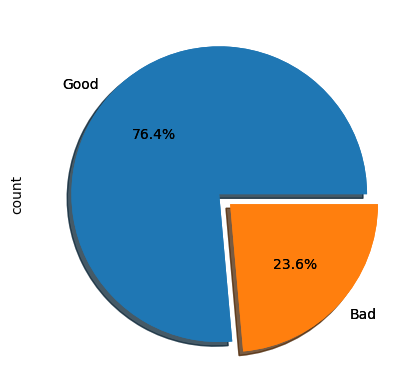

In [115]:


#print(df['AQI'].value_counts())
labels = ['Good', 'Bad']
explode = (0,0.1)
df['AQI'].value_counts().plot.pie(autopct='%1.1f%%', explode = explode, labels = labels, shadow = True)
df['AQI'].value_counts().plot.pie(autopct='%1.1f%%', explode = explode, labels = labels, shadow = True)

In [116]:
#section 3.6.4 : collinéarité entre les variables explicatives
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
X_features = X
vals = []
for i in range(X_features.shape[1]):
    vals.append(VIF(X_features.values, i))
vif_df = pd.DataFrame({'VIF': vals}, index=X_features.columns)
print(vif_df)
grande_col = ['AH', 'C6H6(GT)']
X_filtered = X.drop(columns=grande_col)


                       VIF
CO(GT)            2.125026
PT08.S1(CO)     272.008043
NMHC(GT)          4.195180
C6H6(GT)       1655.980228
PT08.S2(NMHC)   733.871691
NOx(GT)          11.891470
PT08.S3(NOx)     37.406233
NO2(GT)           7.209488
PT08.S4(NO2)    202.576351
PT08.S5(O3)      58.969068
T               239.130328
RH               77.059002
AH             2131.549440
Datetime        514.530930


## Logistic Regression

In [117]:
# Import des bibliothèques nécessaires
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.3, random_state=42)



In [118]:
#variables qui ne contribuent pas significativement au modèle
#ici on va pas utiliser LogisticRegression parce que je vois qu'il ne donne pas de summary() et donc on ne pourra pas avoir accès aux p-values
import statsmodels.api as sm
X_train_const = sm.add_constant(X_train)
log_model = sm.Logit(y_train, X_train_const).fit()
print(log_model.summary())
#on var regarder quand la p-value est plus grande que 0.05, alors on va supprimer les colonnes car elles ne correspondent pas significativement au modèle

Optimization terminated successfully.
         Current function value: 0.400902
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          AQI_lendemain   No. Observations:                 2501
Model:                          Logit   Df Residuals:                     2488
Method:                           MLE   Df Model:                           12
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.2742
Time:                        16:50:30   Log-Likelihood:                -1002.7
converged:                       True   LL-Null:                       -1381.4
Covariance Type:            nonrobust   LLR p-value:                2.099e-154
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            56.4355      5.988      9.425      0.000      44.700      68.171
CO(GT)            0.

In [119]:
#-----après avoir regardé les variables qui ne contribuaient pas significativement au modèle
# 
colonnes_a_supprimer = ['NOx(GT)', 'T', 'CO(GT)']

# Suppression des colonnes
X_train = X_train.drop(columns=colonnes_a_supprimer)
X_test = X_test.drop(columns=colonnes_a_supprimer)
X_train_log=X_train


In [120]:
#on peut refiare le log mnt
log_model = LogisticRegression(max_iter=100)
log_model.fit(X_train, y_train)
y_pred_proba = log_model.predict_proba(X_test)
logit_labels = np.where(y_pred_proba[:, 1] > 0.5, 1, 0)
taux_erreur = 1-accuracy_score(y_test, logit_labels)
print(f"Le taux d'erreur avec le modèle de régression logistique est : {taux_erreur:.4f}")

Le taux d'erreur avec le modèle de régression logistique est : 0.1632


c:\Users\clemd\anaconda3\envs\datamining\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [121]:
print("\nMatrice de confusion :")
conf_matrix = confusion_matrix(y_test, logit_labels)
print(conf_matrix)


Matrice de confusion :
[[127 121]
 [ 54 770]]


In [122]:
print("\nRapport de classification :")
print(classification_report(y_test, logit_labels))


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.70      0.51      0.59       248
         1.0       0.86      0.93      0.90       824

    accuracy                           0.84      1072
   macro avg       0.78      0.72      0.75      1072
weighted avg       0.83      0.84      0.83      1072



## KNN

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.3, random_state=42)

In [124]:
# # Modèle KNN :
# nb_donne = len(df['Date'])
# k_vect = np.array([5, 10, 15, 20 ,30, 40, 50, 75, 100, 150, 200]) #np.arange(1, 181)
# err_loocv = []
# err_5fold = []
# cv_loocv = KFold(n_splits=nb_donne, shuffle=True, random_state=42)  # LOOCV : k-Fold avec k=n
# cv_5fold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV

# for k in k_vect:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     print(f"k = {k}")
#     error_loocv = 1 - np.mean(cross_val_score(knn, X, y, cv=cv_loocv, scoring='accuracy'))
#     error_5fold = 1 - np.mean(cross_val_score(knn, X, y, cv=cv_5fold, scoring='accuracy'))
#     err_5fold.append(error_5fold)
#     err_loocv.append(error_loocv)

# # Courbes
# plt.plot(1 / k_vect, err_loocv, label='LOOCV', color='blue')
# plt.plot(1 / k_vect, err_5fold, label='5-Fold', color='green')
# plt.xlabel('1 / K')
# plt.ylabel('Erreur de la validation croisé')
# plt.title('Erreur de validation croisé pour LOOCV et 5-Fold CV')
# plt.legend()
# plt.grid(True)
# plt.show()


# k_best = k_vect[np.argmin(err_loocv)]
# print(f"On utilise k (LOOCV) = {k_best}")
# k_best = k_vect[np.argmin(err_5fold)]
# print(f"On utilise k (5-Fold) = {k_best}")

## LDA/QDA

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.3, random_state=42)

In [126]:
#-----------------------LDA/QDA------------------------------#
#section 4.7.3 et 4.7.4
# Linear Discriminant Analysis (LDA)
# SincetheLDAestimatorautomaticallyaddsanintercept,weshouldre
# movethecolumncorrespondingtotheinterceptinbothX_trainandX_test.

loo = LeaveOneOut()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lda_model = LDA(store_covariance=True)
qda_model = QDA(store_covariance=True)
#on va faire pareil que l'exo précedent mais sans binomial
#(à nv je pense qu'on aurait pu utiliser cross_validate mais bon)
def mean_error(model, X, y, cv):
    errors = []
    #pour chaque fold
    for i, j in cv.split(X):
        model.fit(X.iloc[i], y.iloc[i])
        predictions = model.predict(X.iloc[j])
        error = np.mean(predictions!=y.iloc[j])
        errors.append(error)
    return np.mean(errors)

lda_loocv_error = mean_error(lda_model, X_train, y_train, loo)
lda_kfold_error = mean_error(lda_model, X_train, y_train, kf)

qda_loocv_error = mean_error(qda_model, X_train, y_train, loo)
qda_kfold_error = mean_error(qda_model, X_train, y_train, kf)

print("LDA LOOCV ", lda_loocv_error) #LDA is way better
print("LDA 5-Fold ", lda_kfold_error)
print("QDA LOOCV ", qda_loocv_error)
print("QDA 5-Fold ", qda_kfold_error)

LDA LOOCV  0.16713314674130347
LDA 5-Fold  0.16793373253493016
QDA LOOCV  0.2686925229908037
QDA 5-Fold  0.2683073852295409


In [127]:
lda_model.fit(X_train, y_train)
y_pred = lda_model.predict(X_test)

In [128]:
# coef = pd.DataFrame({
#     'Variable': X_train.columns,
#     'Coefficient': np.abs(lda_model.coef_[0])
# }).sort_values(by='Coefficient', ascending=False)
# print(coef)
# # #elles contribuent toutes au modèle
X_train_lda=X_train

In [129]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("Rapport de classification :\n", class_report)

Matrice de confusion :
 [[130 118]
 [ 51 773]]
Rapport de classification :
               precision    recall  f1-score   support

         0.0       0.72      0.52      0.61       248
         1.0       0.87      0.94      0.90       824

    accuracy                           0.84      1072
   macro avg       0.79      0.73      0.75      1072
weighted avg       0.83      0.84      0.83      1072



## Prediction

In [130]:
#-----------------------Prediction certain jour et heure-----------------#
def prediction_aqi(jour, heure, model, colonnes):
    point_de_donnees = df[(df['Date'] == jour) & (df['Time'] == heure)]
    
    if not point_de_donnees.empty:
        X_point = point_de_donnees[colonnes]
        prediction = model.predict(X_point)
        print(f"Modèle: {model} -> prrédiction pour {jour} à {heure} : {'Bonne' if prediction[0] == 1 else 'Mauvaise'}")
    else:
        print(f"Modèle: {model} -> aucune donnée pour {jour} à {heure}")


In [131]:
# exemple en utilisant log
#ici j'ai pris le premier point mais on peut changer, limite créer un truc qui fait qu'on demande au visiteur du site 
colonne= X_train_log.columns
prediction_aqi("3/10/2004", "18:00:00", log_model,colonne)

Modèle: LogisticRegression() -> prrédiction pour 3/10/2004 à 18:00:00 : Bonne


In [132]:
#exemple en utilisant LDA
colonne= X_train_lda.columns
prediction_aqi("3/10/2004", "18:00:00", lda_model,colonne)

Modèle: LinearDiscriminantAnalysis(store_covariance=True) -> prrédiction pour 3/10/2004 à 18:00:00 : Bonne


In [133]:
## exemple en utilisant knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
prediction_aqi("3/10/2004", "18:00:00", knn)

TypeError: prediction_aqi() missing 1 required positional argument: 'colonnes'